# Journey to Springfield Kaggle competition

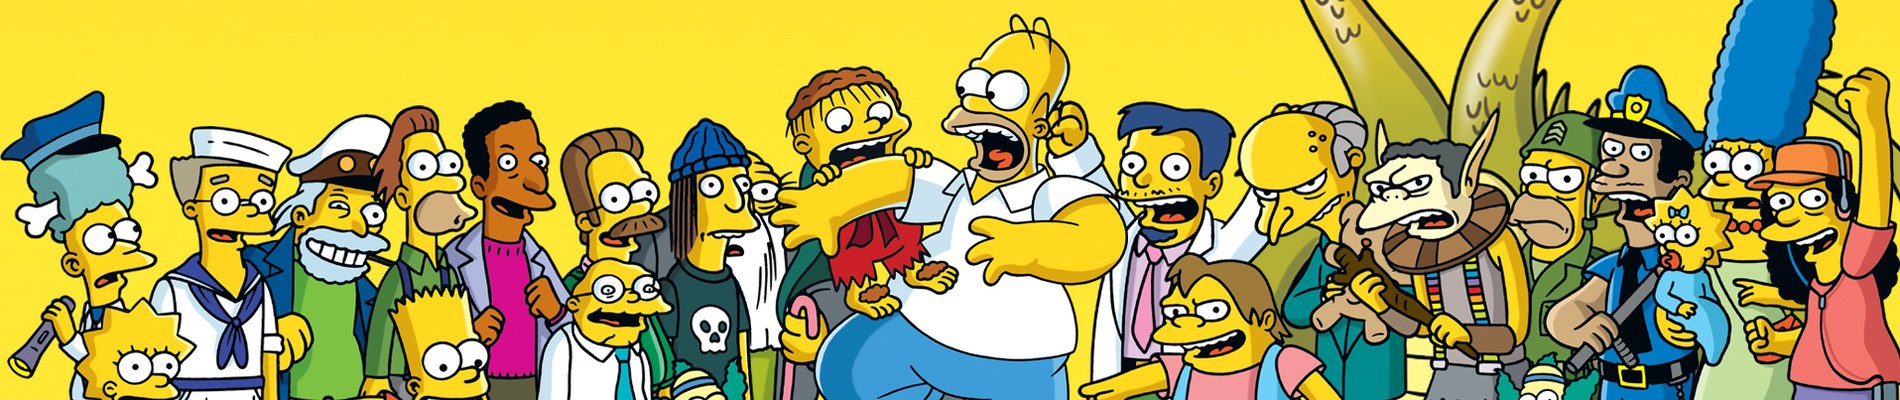

<a href="https://www.kaggle.com/competitions/journey-springfield" >Link to competition</a>

## Importing/downloading modules

In [1]:
!pip uninstall -y Pillow
!pip install Pillow==9.0.1

Found existing installation: Pillow 9.0.1
Uninstalling Pillow-9.0.1:
  Successfully uninstalled Pillow-9.0.1
  Using cached Pillow-9.0.1-cp310-cp310-win_amd64.whl (3.2 MB)


In [2]:
import PIL
import torch
import pickle
import numpy as np
from skimage import io
from PIL import Image
from pathlib import Path, PureWindowsPath
import torch.nn.functional as F
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score
from matplotlib import colors, pyplot as plt
from torch.optim import lr_scheduler

## Check our GPU

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Creating dataset

In [4]:
DATA_MODES = ['train', 'val', 'test']
# We have to rescalse our pictures to 224x224 px
RESCALE_SIZE = 224
# Training on GPU
DEVICE = torch.device("cuda")

In [5]:
class SimpsonsDataset(Dataset):
    """
    uploading files and converting them to tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # convert to tensors and normalize
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    #Imshow for tensors
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path(r'path_to_train_pictures')
TEST_DIR = Path(r'path_to_test_pictures')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
val_dataset = SimpsonsDataset(val_files, mode='val')

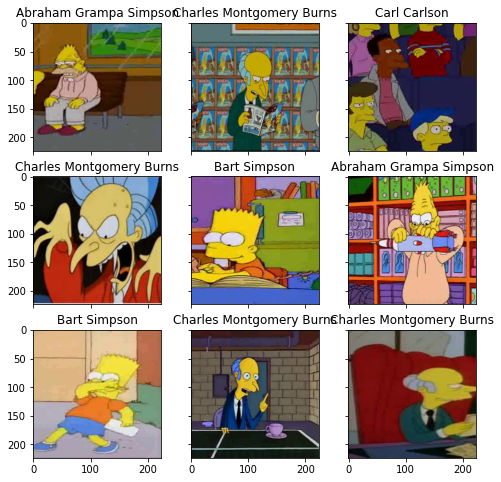

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [16]:
n_classes = len(np.unique(train_val_labels))

## Training and validating functions

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  drop_last = True)

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, scheduler):
    # training function
    
    running_corrects = 0
    processed_data = 0
    scheduler.step()
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        outp = model(x_batch)
        loss = criterion(outp, y_batch)
        loss.backward()
        optimizer.step()
    
        preds = outp.argmax(-1)
    

        running_corrects += (y_batch.data == preds).sum()
        processed_data += x_batch.size(0)

    accuracy = running_corrects.cpu().numpy() / processed_data
    return accuracy

In [ ]:
def eval_epoch(test_loader, model, criterion):
    running_corrects = 0
    processed_data = 0
    model.eval()
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        with torch.no_grad():
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            preds = outp.argmax(-1)

            running_corrects += (y_batch.data == preds).sum()
            processed_data += x_batch.size(0)
    accuracy = running_corrects.cpu().numpy() / processed_data
    return accuracy

In [35]:
def train(train_loader, test_loader, model, criterion, optimizer, scheduler, max_epoch = 10):
    best_acc = 0
    best_model_wts = 0
    acc_history = {'train': [], 'valid': []}
    for i in range(max_epoch):
        tr_acc = train_epoch(train_loader, model, criterion, optimizer, scheduler)
        acc_history['train'].append(tr_acc)

        test_acc = eval_epoch(test_loader, model, criterion)
        acc_history['valid'].append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()

        print('Epoch - {0}/{1}'.format(i + 1, max_epoch))
        print('Train accuracy -', tr_acc)
        print('Valid accuracy -', test_acc)
    print('Best valid accuracy -', best_acc)
    model.load_state_dict(best_model_wts)
    return model, acc_history  

In [ ]:
def check_f1_score(model, val_loader):
    model.eval()
    s = 0
    f1_c = 0
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)

        outp = model(x_batch)
        preds = outp.argmax(-1)
        preds = preds.cpu().numpy()
        f1_c += 1
        fscore = f1_score(preds, y_batch.numpy(), average = 'micro')
        s += fscore 
    return s / f1_c

### one picture predict(you can make prediction on your own picture)

In [39]:
def load_im(path):
    # path - path to picture
    image = Image.open(path)
    image.load()
    return image

def prepare_sample(image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

def transf(x):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                ])
    return transform(x)

def picture_predict(x, model):
    model.eval()
    model.to(DEVICE)
    x = x.to(DEVICE)
    predict = model(x)
    return predict.argmax(-1)

def transformations_predict(path, model):
    x = load_im(path)
    x = prepare_sample(x)
    x = x = np.array(x / 255, dtype='float32')
    x = transf(x)
    x = x[np.newaxis, :]
    return picture_predict(x, model)
# Use transformations_predict function with path to picture and trained model

## resnet152

In [17]:
model_extractor = models.resnet152(pretrained=True)

In [21]:
#freezing weights
for param in model_extractor.parameters():
    param.reqiures_grad = False

In [22]:
#num features - dim of the input feature vector
num_features = 2048
# Changing Fully-Connected layer to our classifier
model_extractor.classifier = nn.Linear(num_features, n_classes)

model_extractor = model_extractor.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_extractor.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
modelg, accf = train(train_loader, val_loader, model_extractor, loss_fn, optimizer, exp_lr_scheduler, max_epoch=20)
'''
I trained this about 6 hours with google collab gpu tesla k80
And I got ~97.22 accuracy with 0.98512 leaderbord score
833/2145 leaderbord place
I think if you do some augmentation and fix the class imbalance
You can get better score
'''

In [ ]:
#visualise accuracy
plt.plot(range(10),accf['train'],label = 'ReLU train', linewidth = 2)
plt.plot(range(10),accf['valid'],label = 'ReLU valid', linewidth = 2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()